# Optimizing Stock Portfolio Allocation <a class='tocSkip'>

## Sang-Yun Oh <a class='tocSkip'>

## Installing Packages in Python

* Default package source for `pip` command is Python Package Index (PyPI)  
    e.g., https://pypi.org/project/yfinance/
* Can also install from github repository: 
    https://pypi.org/project/yfinance/

In [5]:
# install from pypi
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23443 sha256=ccc427fcc01f6dc89e9fe084b53fbbad56d91fe14ad2e9f75c266e84cd30ad76
  Stored in directory: /home/jovyan/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
  Created wheel for multitasking: filename=multitasking-0.0.9-cp37-none-any.whl size=8368 sha256=aef5257f73477cb4312bf362fb09280166d73135ad862b3fc72a306015ba0a8a
  Stored in directory: /home/jovyan/.cache/pip/wheels/37/fa/73/d492849e319038eb4d986f5152e4b19ffb1bc0639da84d2677
Successfully built yfinance multitasking


In [2]:
# install from github
# ! pip install git+https://github.com/ranaroussi/yfinance

In [3]:
import pandas as pd
import numpy as np
import pickle
import cvxpy

## Introduction to Portfolio Theory

### Stock Prices vs. Returns 

* Model stock returns as random variables
* Returns depend on change in stock prices:  
    $$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Linear approximation of $\log(1+x)\approx x$ when $x$ is small. 
* Since daily stock returns are small,
$$ R_t \approx \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$

* Compute the log-returns then difference of log prices (converting data)

### Modeling Stock Returns

* In classical portfolio theory, stock returns are normally distributed
* Daily returns of two stocks: $R_A$ and $R_B$ of two stocks $A$ and $B$
* Jointly normally distributed: bivariate normal distribution: 
$$\begin{aligned}
\begin{pmatrix}
R_A\\ R_B
\end{pmatrix}
\sim
N\left(
\begin{pmatrix}
\mu_A\\ \mu_B
\end{pmatrix},
\begin{pmatrix}
\sigma_A^2 & \sigma_{AB}\\
\sigma_{AB} & \sigma_B^2
\end{pmatrix}
\right)
\end{aligned}$$

* Marginal distributions: 
$$R_A \sim N(\mu_A,\sigma_A^2) \text{, and } R_B \sim N(\mu_B,\sigma_B^2),$$
* Covariance and correlation are
$$\sigma_\text{AB} = \text{Cov}(R_A,R_B) \text{, and } \rho_\text{AB} = \frac{\sigma_\text{AB}}{\sigma_A\sigma_B}$$

### Modeling Portfolio Returns

* Two-stock portfolio: Return for the portfolio $R_p$ is 
$$R_p = R_A x_A + R_B x_B,$$
* Allocations: $x_A$ and $x_B$ are proportions of stocks $A$ and $B$ such that  
$$x_A + x_B = 1$$

* $R_p$ is also normally distributed with following mean and variance:
$$\begin{aligned}
\mu_p &= \text{E}(R_p) \\
    &= \text{E}(R_B)\, x_A + \text{E}(R_B)\, x_B\\
    &= \mu_A x_A + \mu_B x_B\\
\sigma_p^2 &= \text{Var}(R_p) \\
    &= \text{E}\left((R_p - \text{E}(R_p))^2\right) \\
    &= \sigma_A^2\,x_A^2 + \sigma_B^2\,x_B^2 + 2\sigma_{AB}x_A x_B.
\end{aligned}
$$
Note that $\sigma_{AB} = \rho_{AB}\sigma_A\sigma_B$.
* Distribution of the portfolio return is
$$ R_p \sim N(\mu_p, \sigma_p^2) $$

### Hedging Portfolio Risk

* Mean return ($\mu_p$): weighted average of returns
* Risk ($\sigma_p^2$):  Risk of $p$ can be decreased if $\rho<0$
* Hedge risk by having negatively correlated stocks

## Toy Example: Simulating $R_A$ and $R_B$

* $R_A\sim N(0.15, 0.1^2)$ and $R_B\sim N(0.1, 0.05^2)$
* Correlation: $\rho_{AB} = -0.15$
* Portfolio weight distributed evenly: i.e. $x_A = x_B = 0.5$

In [4]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

### Generate random returns

In [5]:
def simulate_returns(A, B, correlation, size=100):
    
    from numpy import sqrt
    from numpy.random import multivariate_normal
    from pandas import DataFrame
    
    # what could go wrong with rounding errors?
    assert(A['proportion'] + B['proportion'] == 1) 

    # construct bivariate normal random variable
    mu = [A['mu'], B['mu']]
    sigma = [[A['sig']**2, correlation*A['sig']*B['sig']],
             [correlation*A['sig']*B['sig'], B['sig']**2]]
    
    # get random observations
    R = multivariate_normal(mu, sigma, size)
    Rp = R[:,0]*A['proportion'] + R[:,1]*B['proportion']
    
    # simulated returns
    R = np.hstack((R, Rp.reshape((-1,1))))
    
    # theoretical properties of portfolio returns
    p = {
        'mu': A['mu']*A['proportion'] + B['mu']*B['proportion'],
        'sig': sqrt(
            A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 
            + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
        }
    
    return p, DataFrame(R, columns=['A', 'B', 'p'])

### Empirical Returns

In [6]:
A = {'mu': 0.15, 'sig': 0.1,  'proportion': 0.5}
B = {'mu': 0.1,  'sig': 0.05, 'proportion': 0.5}

p, R = simulate_returns(A, B, -0.9, 10000)

print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))

print('cor(R_A, R_B) = %1.4f' % np.corrcoef(R.A, R.B)[1,0])

A: mean = 0.15, std = 0.1003
B: mean = 0.10, std = 0.0502
p: mean = 0.13, std = 0.0297
cor(R_A, R_B) = -0.8987


### Empirical Portfolio Returns

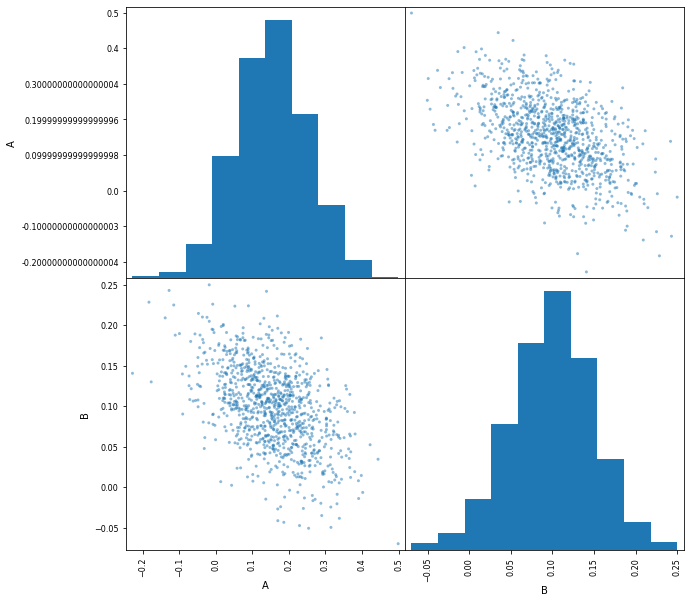

In [7]:
p, R = simulate_returns(A, B, -0.5, 1000)
pd.plotting.scatter_matrix(R.loc[:,['A','B']], figsize=(10,10));

### Theoretical returns

Calculate the volatility ($\sigma^2$) and expected returns ($\mu$):

In [8]:
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('p: mean = %1.2f, std = %1.4f' % (p['mu'], p['sig']))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500
p: mean = 0.12, std = 0.0433


### Independent Portfolio Theoretical returns

If stocks A and B were independent

In [9]:
p, R = simulate_returns(A, B, -0.9, 10000)
print('A: mean = %1.2f, std = %1.4f' % (A['mu'], A['sig']))
print('B: mean = %1.2f, std = %1.4f' % (B['mu'], B['sig']))
print('')
print('p: mean = %1.2f, std = %1.4f (if A and B are correlated )' % (p['mu'], p['sig'])) #sqrt(A['sig']**2*A['proportion']**2 + B['sig']**2*B['proportion']**2 + 2*correlation*A['sig']*B['sig']*A['proportion']*B['proportion'])
print('p: mean = %1.2f, std = %1.4f (if A and B are independent)' % (p['mu'], np.sqrt(0.5**2*A['sig']**2 + 0.5**2*B['sig']**2)))

A: mean = 0.15, std = 0.1000
B: mean = 0.10, std = 0.0500

p: mean = 0.12, std = 0.0296 (if A and B are correlated )
p: mean = 0.12, std = 0.0559 (if A and B are independent)


#### Empirical (Data) Properties 

In [10]:
print('A: mean = %1.2f, std = %1.4f' % (R.A.mean(), R.A.std()))
print('B: mean = %1.2f, std = %1.4f' % (R.B.mean(), R.B.std()))
print('p: mean = %1.2f, std = %1.4f' % (R.p.mean(), R.p.std()))
print('corr(A, B) = %1.4f' % np.corrcoef(R.A, R.B)[0,1])

A: mean = 0.15, std = 0.0999
B: mean = 0.10, std = 0.0504
p: mean = 0.13, std = 0.0294
corr(A, B) = -0.9018


### Efficient frontier of portfolios

* Consider all values of $x_A$ and $x_B$

* For each combination, compute $\mu_p$ and $\sigma_p^2$.

In [11]:
xa = np.linspace(-1, 2, num=101)
pf = pd.DataFrame({'xa':xa, 'xb':1-xa})

# pf, R = simulate_returns(A, B, -0.5, 10000)

corr = -0.5
pf['mu'] = A['mu'] * pf.xa + B['mu'] * pf.xb
pf['sig2'] = ((A['sig']**2 * pf.xa**2) + (B['sig']**2 * pf.xb**2) + (2 * corr * A['sig'] * B['sig'] * pf.xa * pf.xb))

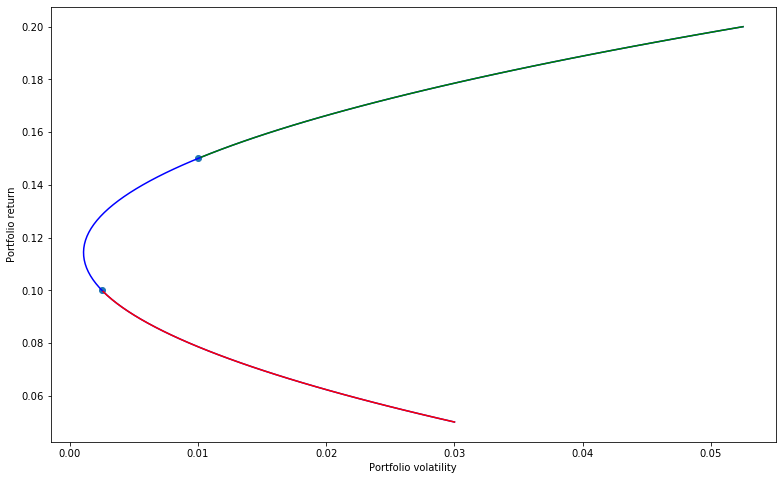

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(13, 8))
plt.plot(pf.sig2, pf.mu, color='b')
plt.plot(pf.sig2[pf.xa<0], pf.mu[pf.xa<0], color='r') # sell stock A to fund purchase of stock B
plt.plot(pf.sig2[pf.xb<0], pf.mu[pf.xb<0], color='g') # sell stock B to fund purchase of stock A
plt.scatter([A['sig']**2, B['sig']**2], [A['mu'], B['mu']])
ax.set_xlabel('Portfolio volatility')
ax.set_ylabel('Portfolio return')
plt.show(p)

* Line is called efficient frontier
* Represents the lower boundary of achievable volatility
* Return and volatility of $A$ and $B$

#### Long and short positions

* Note that `xa` can be negative
* Positive $x_A$ : _long position_ for stock A and indicates a purchase
* Negative $x_A$ : _short position_ stock A and indicates a sale
* _You are selling stocks that you do not own with the expectation that the price of the stock will fall_
* Shorting allows for higher long positions on other stocks.

#### Minimum variance portfolio (MVP)

What is the point at the tip of the parabola? This point indicates what is called the minimum variance portfolio that, regardless of the return, has the minimum volatility. Minimum variance portfolio (MVP) has the minimum volatility of any portfolio achievable.

It can be shown that minimum variance portfolio would have the following allocation $x_A$:

$$x_A = \frac{\sigma_B^2-\sigma_\text{AB}^2}{\sigma_A^2 + \sigma_B^2 – \sigma_\text{AB}^2}$$

The mathematical problem to solve for the minimum variance portfolio can be stated as follows:
$$ \min_{x_A,x_B}\ \ \sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + 2\sigma_{AB} x_A x_B\\
\text{such that }x_A + x_B = 1$$
Here, $\sigma_p^2 = \sigma_A^2 x_A^2 + \sigma_B^2 x_B^2 + 2\sigma_{AB} x_A x_B$ is called the objective function, and $x_A + x_B = 1$ is called the constraint.

The constraint has to be satisfied exactly, and objective wants to be minimized with the freedom of changing the values of $x_A$ and $x_B$.

### Using `cvxpy` for numerical optimization

Calculating analytical solutions is not always possible. There are ways to compute solutions numerically. Although out of scope of our class, a large field in applied math called optimization. The tools from this area allow us to compute solutions for problems such as the one we have here. (For more information, visit the 

### Higher dimensional portfolios

In higher dimensions, the portfolio equantion is written in terms of vectors and matrices. For example, suppose we construct a portfolio consisting of $s$-assets. The portfolio allocation can be written as,
$$\mathbf{1}^\intercal x = 1,$$
where $x$ is an $s$-vector whose sum adds up to 1: i.e., $x_1 + x_2 + \cdots + x_s = 1$.

The portfolio volatility in matrix-vector form looks like:
$$
\begin{pmatrix}x_1 & x_2 & \cdots & x_s\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1s}\\
\sigma_{21} & \sigma_2^2 & \cdots & \sigma_{2s}\\
\vdots & \vdots & & \vdots \\
\sigma_{s1} & \sigma_{s2} & \cdots & \sigma_s^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2 \\ \vdots \\ x_s\end{pmatrix}.
$$
To verify the two stock example result, we check $\sigma_p^2$:
$$
\sigma_p^2 = \begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 & \sigma_{12}\\
\sigma_{21} & \sigma_2^2\\
\end{pmatrix}
\begin{pmatrix}x_1 \\ x_2\end{pmatrix} = 
\begin{pmatrix}x_1 & x_2\end{pmatrix}
\begin{pmatrix}
\sigma_1^2 x_1 + \sigma_{12} x_2\\
\sigma_{21} x_1 + \sigma_2^2 x_2\\
\end{pmatrix} = 
\sigma_1^2 x_1^2 + \sigma_2^2 x_2^2 + 2\sigma_{12} x_1 x_2,
$$
which matches the result from before.

With this notation, we can re-write the problem.

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mathbf{1}^\intercal x = 1,$$

It can be shown that the optimal solution to this problem is,
$$ x^* = (\mathbf{1}^\intercal\Sigma^{-1}\mathbf{1})^{-1}\Sigma^{-1}\mathbf{1} $$.

There are many variations of this problem. In fact the minimum variance portfolio is special case of a more general problem

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

Note that in all of the above problems, the measure of $\mu^*$, expected returns, and covariance matrix have to be provided. In practice, these quantities are estimated from data.

## Portfolio Allocation: Dow Jones component stocks

Stock data can have irregularities such as missing data due stocks being added and removed from the index. Some examples are
* Alcoa Corp. (AA) was removed in 2013
* Apple (AAPL) was added in 2015
* E.I. du Pont de Nemours & Company (DD) was removed and replaced with Dow du Pont (DWDP) as a continuation in 2017

For simplicity the stocks we will use are based on the most recent DJIA constituent companies 

In [94]:
symbols = pd.read_csv('data/tickers.csv').set_index('code')
symbols

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


In [9]:
dowjones_components = [
    'AAPL','AXP','BA','BAC','CAT',
    'CSCO','CVX','DD','DIS','GE',
    'HD','HPQ','IBM','INTC','JNJ',
    'JPM','KO','MCD','MMM',
    'MRK','MSFT','PFE','PG','T',
    'TRV','UTX','VZ','WMT','XOM'
]

import yfinance as yf
rawdata = yf.download(dowjones_components, start="2000-01-01", end="2020-05-10")
rawdata.head()

[*********************100%***********************]  29 of 29 completed

1 Failed download:
- UTX: No data found, symbol may be delisted


Adj Close                                                         \
                AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  0.859423  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.786965  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.798481  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.729382  32.688519  27.796043  14.402134  14.537927  37.125427   

                                                        ...     Volume  \
                  CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  19.126348  30.896286  23.115248  26.585829  ...  5978800.0   
2000-01-04  19.126348  30.051819  24.469286  25.522396  ...  7533100.0   
2000-01-05  19.469425  31.027334  25.484806  25.478096  ...  7598300.0   
2000-01-06  20.298517  31.900925  24.469286  25.818716  ...  4760500.0   

                                                                        \
                  MSFT         PFE         PG          T       TRV UTX   
Date                                                                     
1999-12-31         NaN         NaN        NaN        NaN       NaN NaN   
2000-01-03  53228400.0  12873345.0  4275000.0  5791900.0  336400.0 NaN   
2000-01-04  54119000.0  14208974.0  4270800.0  7173600.0  494400.0 NaN   
2000-01-05  64059600.0  12981591.0  5098400.0  9090000.0  736000.0 NaN   
2000-01-06  54976600.0  11115273.0  6524200.0  7153600.0  660400.0 NaN   

                                              
                   VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  

[5 rows x 174 columns]

In [20]:
rawdata.shape

(5121, 174)

In [21]:
rawdata.index

DatetimeIndex(['1999-12-31', '2000-01-03', '2000-01-04', '2000-01-05',
               '2000-01-06', '2000-01-07', '2000-01-10', '2000-01-11',
               '2000-01-12', '2000-01-13',
               ...
               '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30',
               '2020-05-01', '2020-05-04', '2020-05-05', '2020-05-06',
               '2020-05-07', '2020-05-08'],
              dtype='datetime64[ns]', name='Date', length=5121, freq=None)

In [26]:
rawdata.columns.values

array([('Adj Close', 'AAPL'), ('Adj Close', 'AXP'), ('Adj Close', 'BA'),
       ('Adj Close', 'BAC'), ('Adj Close', 'CAT'), ('Adj Close', 'CSCO'),
       ('Adj Close', 'CVX'), ('Adj Close', 'DD'), ('Adj Close', 'DIS'),
       ('Adj Close', 'GE'), ('Adj Close', 'HD'), ('Adj Close', 'HPQ'),
       ('Adj Close', 'IBM'), ('Adj Close', 'INTC'), ('Adj Close', 'JNJ'),
       ('Adj Close', 'JPM'), ('Adj Close', 'KO'), ('Adj Close', 'MCD'),
       ('Adj Close', 'MMM'), ('Adj Close', 'MRK'), ('Adj Close', 'MSFT'),
       ('Adj Close', 'PFE'), ('Adj Close', 'PG'), ('Adj Close', 'T'),
       ('Adj Close', 'TRV'), ('Adj Close', 'UTX'), ('Adj Close', 'VZ'),
       ('Adj Close', 'WMT'), ('Adj Close', 'XOM'), ('Close', 'AAPL'),
       ('Close', 'AXP'), ('Close', 'BA'), ('Close', 'BAC'),
       ('Close', 'CAT'), ('Close', 'CSCO'), ('Close', 'CVX'),
       ('Close', 'DD'), ('Close', 'DIS'), ('Close', 'GE'),
       ('Close', 'HD'), ('Close', 'HPQ'), ('Close', 'IBM'),
       ('Close', 'INTC'), ('Close', '

## Data Format

### Hierarchical Indexing

* Column indexing is hierarchical
* Adjusted close, close, high, low, open, and volume are given for each stock symbol

In [15]:
rawdata.columns.levels

FrozenList([['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], ['AAPL', 'AXP', 'BA', 'BAC', 'CAT', 'CSCO', 'CVX', 'DD', 'DIS', 'GE', 'HD', 'HPQ', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'PFE', 'PG', 'T', 'TRV', 'UTX', 'VZ', 'WMT', 'XOM']])

* Column levels can be named:

In [30]:
rawdata.columns = rawdata.columns.set_names(['Value', 'Symbol'])
rawdata.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
1999-12-31       NaN        NaN        NaN        NaN        NaN        NaN   
2000-01-03  0.859423  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.786965  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.798481  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.729382  32.688519  27.796043  14.402134  14.537927  37.125427   

Value                                                   ...     Volume  \
Symbol            CVX         DD        DIS         GE  ...        MRK   
Date                                                    ...              
1999-12-31        NaN        NaN        NaN        NaN  ...        NaN   
2000-01-03  19.126348  30.896286  23.115248  26.585829  ...  5978800.0   
2000-01-04  19.126348  30.051819  24.469286  25.522396  ...  7533100.0   
2000-01-05  19.469425  31.027334  25.484806  25.478096  ...  7598300.0   
2000-01-06  20.298517  31.900925  24.469286  25.818716  ...  4760500.0   

Value                                                                   \
Symbol            MSFT         PFE         PG          T       TRV UTX   
Date                                                                     
1999-12-31         NaN         NaN        NaN        NaN       NaN NaN   
2000-01-03  53228400.0  12873345.0  4275000.0  5791900.0  336400.0 NaN   
2000-01-04  54119000.0  14208974.0  4270800.0  7173600.0  494400.0 NaN   
2000-01-05  64059600.0  12981591.0  5098400.0  9090000.0  736000.0 NaN   
2000-01-06  54976600.0  11115273.0  6524200.0  7153600.0  660400.0 NaN   

Value                                         
Symbol             VZ        WMT         XOM  
Date                                          
1999-12-31        NaN        NaN         NaN  
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  

[5 rows x 174 columns]

* Subsetting first level of hierarchical indexing: `Adj Close`

In [17]:
rawdata['Adj Close'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,3.460857,34.683704,25.741438,14.306108,11.845388,41.433525,17.419516,31.433344,23.115221,26.297499,...,31.689192,37.393559,15.987980,30.989897,17.282593,19.621847,19.131641,21.479733,45.984715,21.818495
2000-01-04,3.169071,33.374104,25.701408,13.456975,11.693136,39.109055,17.419516,30.574173,24.469255,25.245590,...,30.576269,36.130390,15.392351,30.393608,16.271378,19.361706,18.347233,20.785389,44.264072,21.400583
2000-01-05,3.215448,32.526413,27.302753,13.604647,11.967190,38.989223,17.731968,31.566656,25.484774,25.201761,...,31.777040,36.511333,15.643135,29.815363,16.524181,19.213058,17.983746,21.479733,43.360710,22.567265
2000-01-06,2.937188,33.189102,27.582977,14.767599,12.576205,38.342190,18.487068,32.455444,24.469255,25.538691,...,32.040642,35.288280,16.207415,31.188662,16.175280,19.584684,18.844660,21.370630,43.833904,23.733942


* Subsetting first level of hierarchical indexing: `Volume`

In [18]:
rawdata.loc[:, 'Volume'].head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,133949200.0,6471200.0,2638200.0,13705800.0,5055000.0,53076000.0,4387600.0,1296000.0,8402200.0,22952500.0,...,5978800.0,53228400.0,12213800.0,4275000.0,5791900.0,336400.0,2140400.0,4663700.0,8369900.0,13458200.0
2000-01-04,128094400.0,10440800.0,3592100.0,27293400.0,6181400.0,50805600.0,3702400.0,2073600.0,16051100.0,23006200.0,...,7533100.0,54119000.0,13481000.0,4270800.0,7173600.0,494400.0,3367000.0,5005800.0,6745100.0,14510800.0
2000-01-05,194580400.0,8646200.0,7631700.0,22855600.0,6398600.0,68524000.0,5567600.0,3653200.0,19823800.0,28384500.0,...,7598300.0,64059600.0,12316500.0,5098400.0,9090000.0,736000.0,3904600.0,6368500.0,7018700.0,17485000.0
2000-01-06,191993200.0,10990900.0,4922200.0,17307000.0,5140600.0,48242600.0,4353400.0,4885500.0,7903100.0,20668100.0,...,4760500.0,54976600.0,10545800.0,6524200.0,7153600.0,660400.0,6148600.0,4705600.0,6544500.0,19461600.0


* Subsetting second level is slightly harder: `AAPL`

In [31]:
idx = pd.IndexSlice
rawdata.loc[:, idx[:, 'AAPL']].head()

Value,Adj Close,Close,High,Low,Open,Volume
Symbol,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
1999-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-03,0.859423,0.999442,1.004464,0.907924,0.936384,535796800.0
2000-01-04,0.786965,0.915179,0.987723,0.903460,0.966518,512377600.0
2000-01-05,0.798481,0.928571,0.987165,0.919643,0.926339,778321600.0
2000-01-06,0.729382,0.848214,0.955357,0.848214,0.947545,767972800.0


* Subsetting `Open`, `High`, `Low`, and `Close` (OHLC) for `AAPL`:

In [20]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']]
aapl.head()

Value,Close,High,Low,Open
Symbol,AAPL,AAPL,AAPL,AAPL
Date,,,,
1999-12-31,NaN,NaN,NaN,NaN
2000-01-03,3.997768,4.017857,3.631696,3.745536
2000-01-04,3.660714,3.950893,3.613839,3.866071
2000-01-05,3.714286,3.948661,3.678571,3.705357
2000-01-06,3.392857,3.821429,3.392857,3.790179


* Drop redudant index level, `AAPL`:

In [21]:
aapl = rawdata.loc[:, idx['Close':'Open', 'AAPL']].droplevel('Symbol', axis=1).tail(60)
aapl.head()

Value,Close,High,Low,Open
Date,,,,
2020-02-13,324.869995,326.220001,323.350006,324.190002
2020-02-14,324.950012,325.980011,322.850006,324.739990
2020-02-18,319.000000,319.750000,314.609985,315.359985
2020-02-19,323.619995,324.570007,320.000000,320.000000
2020-02-20,320.299988,324.649994,318.209991,322.630005


### Example Figure: Candlestick Chart for 3M

In [32]:
mmm = rawdata.loc[:, idx['Close':'Open', 'MMM']].droplevel('Symbol', axis=1).tail(60)

import altair as alt

open_close_color = alt.condition(
    "datum.Open <= datum.Close",
    alt.value("#06982d"), # green for increase
    alt.value("#ae1325"), # red for decrease
) 

base = alt.Chart(mmm.reset_index()).encode(
    alt.X('Date:T',
          axis=alt.Axis(
              format='%m-%d-%Y',
              labelAngle=-90)
    ),
    color=open_close_color
)

rule = base.mark_rule().encode(
    alt.Y(
        'Low:Q',
        title='Price',
        scale=alt.Scale(zero=False),
    ),
    alt.Y2('High:Q')
)

bar = base.mark_bar().encode(
    alt.Y('Open:Q'),
    alt.Y2('Close:Q')
)

rule + bar

alt.LayerChart(...)

### Example Figure: Adjusted close prices

In [38]:
first10 = rawdata.loc[:, idx['Adj Close', ['MMM', 'MRK', 'PFE', 'PG', 'UNH', 'JNJ']]].tail(60)
first10.head()

Value        Adj Close                                              
Symbol             JNJ         MMM        MRK        PFE          PG
Date                                                                
2020-02-13  145.212158  153.023285  78.755493  33.312485  121.161919
2020-02-14  145.250854  154.220581  79.408836  32.933624  122.306061
2020-02-18  144.293015  152.180405  79.226288  32.762234  121.074661
2020-02-19  144.099533  152.620987  78.784325  32.681049  121.627335
2020-02-20  143.548065  151.873886  79.255112  32.338272  122.732689

* Stacking transforms data into long-format:  
    _Note: unstack does the opposite_

In [34]:
healthcare = first10.stack('Symbol')
healthcare

Value               Adj Close
Date       Symbol            
2020-02-13 JNJ     145.212158
           MMM     153.023285
           MRK      78.755493
           PFE      33.312485
           PG      121.161919
...                       ...
2020-05-08 JNJ     144.784729
           MMM     142.247681
           MRK      74.010338
           PFE      33.908672
           PG      113.175537

[300 rows x 1 columns]

In [99]:
healthcare.columns.values

array(['Adj Close'], dtype=object)

In [95]:
healthcare.index

MultiIndex([('2020-02-13', 'JNJ'),
            ('2020-02-13', 'MMM'),
            ('2020-02-13', 'MRK'),
            ('2020-02-13', 'PFE'),
            ('2020-02-13',  'PG'),
            ('2020-02-14', 'JNJ'),
            ('2020-02-14', 'MMM'),
            ('2020-02-14', 'MRK'),
            ('2020-02-14', 'PFE'),
            ('2020-02-14',  'PG'),
            ...
            ('2020-05-07', 'JNJ'),
            ('2020-05-07', 'MMM'),
            ('2020-05-07', 'MRK'),
            ('2020-05-07', 'PFE'),
            ('2020-05-07',  'PG'),
            ('2020-05-08', 'JNJ'),
            ('2020-05-08', 'MMM'),
            ('2020-05-08', 'MRK'),
            ('2020-05-08', 'PFE'),
            ('2020-05-08',  'PG')],
           names=['Date', 'Symbol'], length=300)

In [35]:
base = alt.Chart(healthcare.reset_index()).mark_line().encode(
    x=alt.X('Date:T',
            axis=alt.Axis(
                format='%m-%d-%Y',
                labelAngle=-90)
    ),
    y='Adj Close:Q',
    color='Symbol:N'
)
base

alt.Chart(...)

* Inspect missing values:  

In [39]:
rawdata['Adj Close'].isna()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MRK,MSFT,PFE,PG,T,TRV,UTX,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-12-31,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2000-01-03,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2000-01-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2000-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2000-01-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2020-05-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2020-05-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [100]:
rawdata['Adj Close'].isna().sum(axis=0)

Symbol
AAPL       1
AXP        1
BA         1
BAC        1
CAT        1
CSCO       1
CVX        1
DD         1
DIS        1
GE         1
HD         1
HPQ        1
IBM        1
INTC       1
JNJ        1
JPM        1
KO         1
MCD        1
MMM        1
MRK        1
MSFT       1
PFE        1
PG         1
T          1
TRV        1
UTX     5121
VZ         1
WMT        1
XOM        1
dtype: int64

In [42]:
rawdata['Adj Close'].isna().sum(axis=1)

Date
1999-12-31    29
2000-01-03     1
2000-01-04     1
2000-01-05     1
2000-01-06     1
              ..
2020-05-04     1
2020-05-05     1
2020-05-06     1
2020-05-07     1
2020-05-08     1
Length: 5121, dtype: int64

In [40]:
anymissing = rawdata['Adj Close'].isna().any(axis=1)
rawdata.loc[anymissing]

Value       Adj Close                                                \
Symbol           AAPL        AXP          BA        BAC         CAT   
Date                                                                  
1999-12-31        NaN        NaN         NaN        NaN         NaN   
2000-01-03   0.859423  34.160576   25.940277  13.952057   13.693107   
2000-01-04   0.786965  32.870731   25.899939  13.123939   13.517111   
2000-01-05   0.798481  32.035824   27.513651  13.267960   13.833909   
2000-01-06   0.729382  32.688519   27.796043  14.402134   14.537927   
...               ...        ...         ...        ...         ...   
2020-05-04  72.602936  85.077232  131.460007  22.362524  105.232056   
2020-05-05  73.692627  85.431808  125.400002  22.099207  106.394569   
2020-05-06  74.452927  82.733139  121.860001  21.796877  105.183197   
2020-05-07  75.223137  85.421959  128.649994  22.274752  104.811981   
2020-05-08  77.013580  88.150185  133.440002  22.986685  109.520660   

Value                                                               ...  \
Symbol           CSCO        CVX         DD         DIS         GE  ...   
Date                                                                ...   
1999-12-31        NaN        NaN        NaN         NaN        NaN  ...   
2000-01-03  40.118656  19.126348  30.896286   23.115248  26.585829  ...   
2000-01-04  37.867947  19.126348  30.051819   24.469286  25.522396  ...   
2000-01-05  37.751926  19.469425  31.027334   25.484806  25.478096  ...   
2000-01-06  37.125427  20.298517  31.900925   24.469286  25.818716  ...   
...               ...        ...        ...         ...        ...  ...   
2020-05-04  40.037785  85.283859  43.814922  103.180000   6.180224  ...   
2020-05-05  40.144291  86.636230  43.785530  101.059998   6.170272  ...   
2020-05-06  39.844131  83.987434  43.148685  100.879997   5.951327  ...   
2020-05-07  40.057144  86.403069  43.854111  105.570000   6.080704  ...   
2020-05-08  41.625740  89.042549  45.980194  109.160004   6.259841  ...   

Value           Volume                                                 \
Symbol             MRK        MSFT         PFE         PG           T   
Date                                                                    
1999-12-31         NaN         NaN         NaN        NaN         NaN   
2000-01-03   5978800.0  53228400.0  12873345.0  4275000.0   5791900.0   
2000-01-04   7533100.0  54119000.0  14208974.0  4270800.0   7173600.0   
2000-01-05   7598300.0  64059600.0  12981591.0  5098400.0   9090000.0   
2000-01-06   4760500.0  54976600.0  11115273.0  6524200.0   7153600.0   
...                ...         ...         ...        ...         ...   
2020-05-04   8444900.0  30372900.0  19893512.0  5636000.0  35164100.0   
2020-05-05   7062400.0  36839200.0  24123952.0  5425200.0  24626100.0   
2020-05-06  11846300.0  32139300.0  24047432.0  7892200.0  45094200.0   
2020-05-07  12025200.0  28316000.0  33546080.0  8762800.0  31814300.0   
2020-05-08   8389000.0  30877800.0  19893618.0  9279900.0  24036500.0   

Value                                                         
Symbol            TRV UTX          VZ        WMT         XOM  
Date                                                          
1999-12-31        NaN NaN         NaN        NaN         NaN  
2000-01-03   336400.0 NaN   4663843.0  8369900.0  13458200.0  
2000-01-04   494400.0 NaN   5005878.0  6745100.0  14510800.0  
2000-01-05   736000.0 NaN   6368681.0  7018700.0  17485000.0  
2000-01-06   660400.0 NaN   4705763.0  6544500.0  19461600.0  
...               ...  ..         ...        ...         ...  
2020-05-04  1657700.0 NaN  11833600.0  5935900.0  27465600.0  
2020-05-05  1798700.0 NaN  10902400.0  6445800.0  29276200.0  
2020-05-06  1309000.0 NaN  12460400.0  5769700.0  22659000.0  
2020-05-07  1333100.0 NaN  14083100.0  9115200.0  22160300.0  
2020-05-08  1125200.0 NaN  11097900.0  6943600.0  19977400.0  

[5121 rows x 174 columns]

* Raytheon bought United Technologies in April  
    Let's remove UTX and keep other recent data
* Remove missing day: '1999-12-31'
* Fill '2001-09-12', '2016-01-18' with [`pandas.DataFrame.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

In [45]:
data_all = pd.concat([
    rawdata.loc[:, idx[:, :'TRV']], 
    rawdata.loc[:, idx[:, 'VZ':]], 
], axis=1).fillna(method='pad').loc['2000-01-03':]

data_all.columns = data_all.columns.set_names(['Value', 'Symbol'])

* Double check: did we remove all missing values?

In [101]:
(data_all.isna().sum(axis=None)>0).any()

False

* Reset symbols to what is in `data` variable

In [47]:
symbols = symbols.loc[data_all.columns.levels[1].to_list()]
symbols

,name
code,
AAPL,Apple Inc (AAPL)
AXP,American Express Co. (AXP)
BA,The Boeing Co. (BA)
BAC,Bank of America Corp. (BAC)
CAT,Caterpillar Inc. (CAT)
CSCO,Cisco Systems Inc. (CSCO)
CVX,Chevron Corporation (CVX)
DD,E.I. du Pont de Nemours and Co. (DD)
DIS,Disney (Walt) Co. (The) (DIS)


In [48]:
data_all.head()

Value      Adj Close                                                         \
Symbol          AAPL        AXP         BA        BAC        CAT       CSCO   
Date                                                                          
2000-01-03  0.859423  34.160576  25.940277  13.952057  13.693107  40.118656   
2000-01-04  0.786965  32.870731  25.899939  13.123939  13.517111  37.867947   
2000-01-05  0.798481  32.035824  27.513651  13.267960  13.833909  37.751926   
2000-01-06  0.729382  32.688519  27.796043  14.402134  14.537927  37.125427   
2000-01-07  0.763932  33.164429  28.602896  14.024072  15.013142  39.306557   

Value                                                   ...      High  \
Symbol            CVX         DD        DIS         GE  ...       XOM   
Date                                                    ...             
2000-01-03  19.126348  30.896286  23.115248  26.585829  ...  40.37500   
2000-01-04  19.126348  30.051819  24.469286  25.522396  ...  39.09375   
2000-01-05  19.469425  31.027334  25.484806  25.478096  ...  40.87500   
2000-01-06  20.298517  31.900925  24.469286  25.818716  ...  42.90625   
2000-01-07  20.655876  32.614384  24.082424  26.818453  ...  43.12500   

Value             Low                          Open                    \
Symbol             VZ      WMT       XOM         VZ     WMT       XOM   
Date                                                                    
2000-01-03  53.622120  65.5000  38.93750  54.521442  68.375  39.75000   
2000-01-04  51.486229  64.1875  38.25000  53.678326  65.500  38.68750   
2000-01-05  52.610382  62.1875  38.90625  53.060043  63.875  39.00000   
2000-01-06  52.497967  62.6875  40.09375  53.678326  63.000  40.31250   
2000-01-07  51.992096  64.5000  42.00000  52.947628  64.500  42.96875   

Value          Volume                         
Symbol             VZ        WMT         XOM  
Date                                          
2000-01-03  4663843.0  8369900.0  13458200.0  
2000-01-04  5005878.0  6745100.0  14510800.0  
2000-01-05  6368681.0  7018700.0  17485000.0  
2000-01-06  4705763.0  6544500.0  19461600.0  
2000-01-07  5043907.0  7976900.0  16603800.0  

[5 rows x 168 columns]

### Adjusted Close

* [Adjusted closing prices](https://help.yahoo.com/kb/SLN28256.html) accounts for splits, etc

In [49]:
data = data_all['Adj Close']
data.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.859423,34.160576,25.940277,13.952057,13.693107,40.118656,19.126348,30.896286,23.115248,26.585829,...,27.387001,30.698004,36.932102,14.565584,30.248369,15.941188,19.119379,20.573511,45.262192,20.461939
2000-01-04,0.786965,32.870731,25.899939,13.123939,13.517111,37.867947,19.126348,30.051819,24.469286,25.522396,...,26.298779,29.619884,35.684532,14.022944,29.666332,15.008461,18.865917,19.908472,43.568573,20.070005
2000-01-05,0.798481,32.035824,27.513651,13.267960,13.833909,37.751926,19.469425,31.027334,25.484806,25.478096,...,27.060537,30.783119,36.060772,14.251427,29.101934,15.241655,18.721069,20.573511,42.679428,21.164143
2000-01-06,0.729382,32.688519,27.796043,14.402134,14.537927,37.125427,20.298517,31.900925,24.469286,25.818716,...,29.236986,31.038458,34.852810,14.765505,30.442392,14.919894,19.083178,20.469007,43.145149,22.258282
2000-01-07,0.763932,33.164429,28.602896,14.024072,15.013142,39.306557,20.655876,32.614384,24.082424,26.818453,...,29.817362,34.017471,35.308266,15.765108,32.876366,15.047773,19.843601,20.317860,46.405392,22.192961


### Log returns from stock prices

* Data is price per share
* We need daily returns from the prices
* Given the prices $P_t$ and $P_{t-1}$ for time $t$, the return is, 
$$ R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1 $$

* Approximation $\log(1+x)\approx x$ is good when $x$ is small
* Since daily returns of stocks are small, calculate as returns,
$$ r_t = \log(1 + R_t) = \log\left(\frac{P_t}{P_{t-1}}\right) = \log(P_t) - \log(P_{t-1})$$
So, in order to compute the log-returns, compute the difference of log prices:

In [50]:
logret = np.log(data).diff()
logret.head()

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.088077,-0.038490,-0.001556,-0.061189,-0.012936,-0.057736,0.000000,-0.027713,0.056926,-0.040822,...,-0.040546,-0.035752,-0.034364,-0.037967,-0.019429,-0.060292,-0.013345,-0.032859,-0.038136,-0.019340
2000-01-05,0.014527,-0.025728,0.060442,0.010914,0.023166,-0.003069,0.017778,0.031945,0.040664,-0.001737,...,0.028554,0.038521,0.010488,0.016162,-0.019208,0.015418,-0.007707,0.032859,-0.020619,0.053082
2000-01-06,-0.090514,0.020169,0.010211,0.082024,0.049638,-0.016734,0.041703,0.027766,-0.040664,0.013281,...,0.077358,0.008261,-0.034072,0.035437,0.045031,-0.021337,0.019158,-0.005092,0.010853,0.050406
2000-01-07,0.046281,0.014454,0.028614,-0.026601,0.032165,0.057089,0.017452,0.022118,-0.015936,0.037991,...,0.019656,0.091647,0.012983,0.065505,0.076918,0.008535,0.039074,-0.007412,0.072846,-0.002939


* First time period is NaN since there is no data corresponding to $-1$.

* Note that $100\cdot r_t$% represent daily percentage returns.

### Estimate expected returns

Estimate the daily expected returns by computing the means:

In [57]:
mu = logret[1:].mean(axis=0)
mu

Symbol
AAPL    0.000878
AXP     0.000185
BA      0.000320
BAC     0.000098
CAT     0.000406
CSCO    0.000007
CVX     0.000300
DD      0.000078
DIS     0.000303
GE     -0.000283
HD      0.000329
HPQ     0.000016
IBM     0.000094
INTC    0.000150
JNJ     0.000329
JPM     0.000243
KO      0.000203
MCD     0.000395
MMM     0.000322
MRK     0.000172
MSFT    0.000312
PFE     0.000165
PG      0.000258
T       0.000108
TRV     0.000313
VZ      0.000191
WMT     0.000192
XOM     0.000141
dtype: float64

### Estimate covariance matrix (volatility structure)

Estimate the covarince matrix of returns:

In [58]:
sigma = logret.cov()
sigma

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Symbol,,,,,,,,,,,,,,,,,,,,,
AAPL,0.000711,0.000222,0.000162,0.000240,0.000201,0.000297,0.000129,0.000171,0.000176,0.000196,...,0.000129,0.000095,0.000229,0.000093,0.000067,0.000120,0.000142,0.000104,0.000101,0.000121
AXP,0.000222,0.000524,0.000242,0.000445,0.000255,0.000251,0.000198,0.000271,0.000246,0.000284,...,0.000183,0.000147,0.000215,0.000152,0.000111,0.000169,0.000239,0.000148,0.000129,0.000176
BA,0.000162,0.000242,0.000447,0.000250,0.000205,0.000180,0.000172,0.000224,0.000188,0.000212,...,0.000148,0.000114,0.000165,0.000120,0.000090,0.000122,0.000166,0.000101,0.000098,0.000156
BAC,0.000240,0.000445,0.000250,0.000849,0.000296,0.000266,0.000221,0.000322,0.000249,0.000335,...,0.000208,0.000153,0.000220,0.000171,0.000119,0.000180,0.000276,0.000153,0.000126,0.000192
CAT,0.000201,0.000255,0.000205,0.000296,0.000421,0.000203,0.000187,0.000274,0.000185,0.000223,...,0.000182,0.000115,0.000176,0.000125,0.000093,0.000129,0.000167,0.000110,0.000106,0.000172
CSCO,0.000297,0.000251,0.000180,0.000266,0.000203,0.000597,0.000137,0.000199,0.000212,0.000223,...,0.000151,0.000103,0.000271,0.000115,0.000081,0.000139,0.000165,0.000131,0.000118,0.000130
CVX,0.000129,0.000198,0.000172,0.000221,0.000187,0.000137,0.000300,0.000193,0.000150,0.000167,...,0.000127,0.000118,0.000142,0.000114,0.000078,0.000116,0.000154,0.000099,0.000072,0.000228
DD,0.000171,0.000271,0.000224,0.000322,0.000274,0.000199,0.000193,0.000509,0.000201,0.000237,...,0.000189,0.000133,0.000170,0.000136,0.000111,0.000141,0.000187,0.000118,0.000113,0.000177
DIS,0.000176,0.000246,0.000188,0.000249,0.000185,0.000212,0.000150,0.000201,0.000370,0.000199,...,0.000139,0.000111,0.000174,0.000113,0.000083,0.000131,0.000153,0.000122,0.000102,0.000138


### Visualize volatility structure

* Heatmap visualization of covariance and correlation

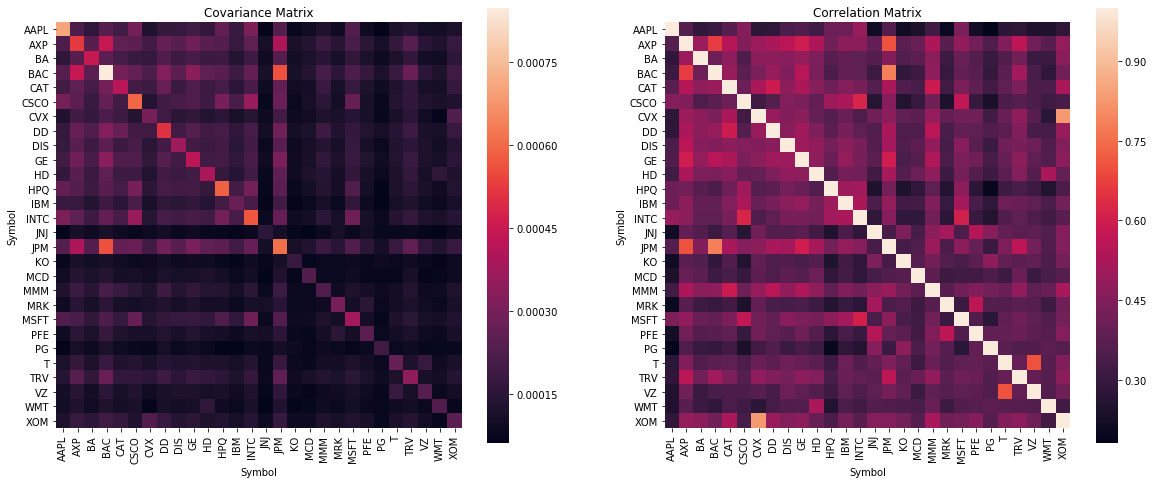

In [36]:
import seaborn as sns
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov(),  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr(), square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

* Reordering variables group similar stocks together

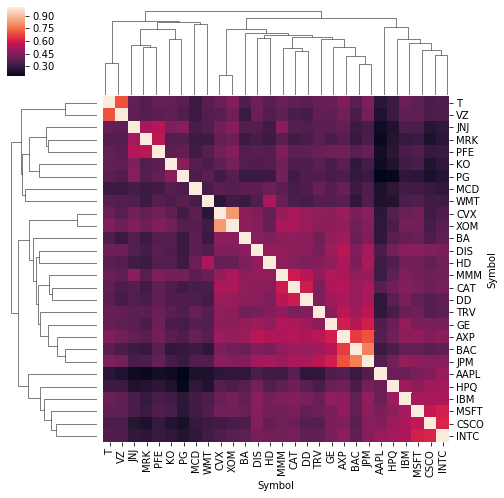

In [37]:
clmap = sns.clustermap(logret.corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

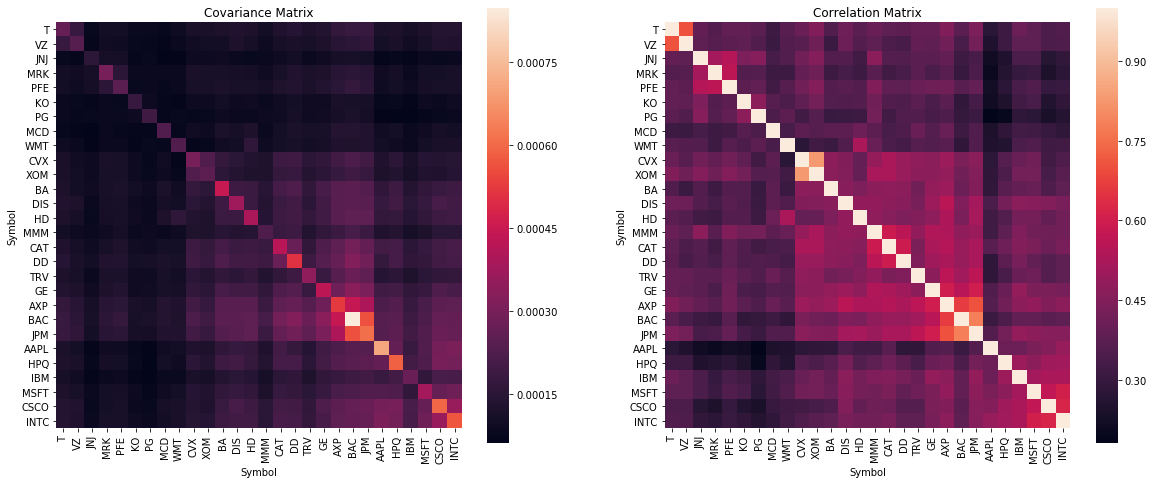

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.heatmap(logret.cov().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Covariance Matrix')
sns.heatmap(logret.corr().iloc[ordering, ordering], square=True, ax=ax[1]).set_title('Correlation Matrix')
fig.show()

## Calculate Minimum Variance Portfolio

* $\Sigma$ matrix is all that is specified
* $\Sigma$ characterizes the market
* Minimize variance of portfolio $R_p$

In [59]:
import cvxpy as cvx

s, _ = sigma.shape # calculated from data

w = cvx.Variable(s) # variables
risk = cvx.quad_form(w, sigma.values)  # objective function
prob = cvx.Problem(cvx.Minimize(risk), # optimization problem 
               [cvx.sum(w) == 1])      # fully invested portfolio constraint
prob.solve()

8.700183897369449e-05

In [60]:
w.value

array([ 0.02018859, -0.07531678, -0.00693043, -0.01013867, -0.01083238,
       -0.01628601,  0.04312051, -0.04165194,  0.01085443, -0.01440342,
       -0.02249636,  0.01441894,  0.11148298, -0.02366012,  0.22005576,
       -0.0337037 ,  0.15646888,  0.1454129 ,  0.0946773 ,  0.00399497,
        0.0147105 ,  0.03232869,  0.12350192,  0.00706322,  0.01421028,
        0.10003852,  0.13061886,  0.01227252])

* Positive weights indicate long positions
* Negative weights indicate [short positions](https://en.wikipedia.org/wiki/Short_(finance))
* Must sum to 1 (constraint)

* Other portfolio optimization variations:  
    http://nbviewer.jupyter.org/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb

* `cvxpy` package makes it easy to solve many types of problems easily
* Portfolio allocation problem with target expected return constraint:

$$ \min_{x\in\mathbb{R}^s}\ \ x^\intercal \Sigma x\\
\text{subject to }\mu^\intercal x\geq \mu^* \text{, and } \mathbf{1}^\intercal x = 1,$$

* Expected returns, $\mu$, is estimated from data (also $\Sigma$)
* Investor specifies target return $\mu^*$

In [67]:
import cvxpy as cvx

s,_ = sigma.shape

w = cvx.Variable(s)
risk = cvx.quad_form(w, sigma.values)
prob = cvx.Problem(cvx.Minimize(risk), 
               [
                   cvx.sum(w) == 1,
                   mu.values@w >= 0.001
               ])
prob.solve()

0.00021313691268395294

In [68]:
w.value

array([ 0.28495168, -0.09140776,  0.06845433, -0.08243048,  0.16654576,
       -0.14050637,  0.29861471, -0.14964163,  0.10520971, -0.46069054,
        0.05630543, -0.10180157, -0.00304571, -0.07757225,  0.43687345,
        0.11782188,  0.02608101,  0.28525736,  0.2839714 , -0.06736223,
        0.10396007, -0.02687324,  0.15910775, -0.13560131,  0.08530101,
        0.16496399,  0.0291177 , -0.33560417])

* Higher target return achieved with more short positions
* Constraint: $\mu^\intercal w=0.001$
* Constraint: $\mathbf{1}^\intercal w=1$.

In [69]:
w.value.sum()

0.9999999999999994

In [70]:
np.dot(mu.values,w.value)

0.001

### Making the investment: portfolio return along a time series

* Investing 1 dollar in a stock with 3% return over one time period makes me 3 cents:  
    $$\$1 \cdot (1 + 0.03) = 1.03$$
    
* Investing a portfolio of worth $A_0$ dollars returns,
    $$ A := A_0 (1+{r^{(t)}}^T w^{(t)}), $$
    where elements of $r^{(t)}$ are returns at time $t$ and $w$ is portfolio allocation

* Take allocation `w.value` and compute portfolio returns using historical returns: `logret`.

**Derivation of $A := A_0 (1+{r^{(t)}}^T w^{(t)})$:**


$$
\begin{aligned}
A_1 &= A_0(1 + r_1): \quad r_1 \text{ is return of stock 1 for some time period t} \\
A_1w_1 &= A_0w_1(1 + r_1) \\
&= A_0(w_1 + r_1w_1) \\
A_2w_2 &= A_0(w_2 + r_2w_2) \\
\vdots \\
\implies \sum_{i=1}^{28} A_iw_i &= \sum_{i=1}^{28}A_0(w_i + r_iw_i)\\
\implies &A := A_0\big(1 + \underbrace{\sum_{i=1}^{28}r_iw_i}_{r^Tw}\big) \quad A \text{ is total return at some time period t} 
\end{aligned}
$$

Consider a time series where time period $t \in \{1,\dots, n\}$:
$$
\begin{aligned}
A^{(1)} &= A^{(0)} \left(1+{r^{(1)}}^T w^{(1)}\right) \\
A^{(2)} &= A^{(1)} \left(1+{r^{(2)}}^T w^{(2)}\right) \\
\vdots \\
A^{(t)} &= A^{(t-1)} \left(1+{r^{(t)}}^T w^{(t)}\right) \\
\vdots \\
\implies A^{(n)} &= A^{(0)} \left(1+{r^{(1)}}^T w^{(1)}\right)\left(1+{r^{(2)}}^T w^{(2)}\right) \cdots \left(1+{r^{(n-1)}}^T w^{(n-1)}\right) 
\end{aligned}
$$

In [103]:
earned = np.dot(logret.fillna(method='bfill').values, w.value)  #r^t w, return of minimum variance portfolio across a series of time peirods
earned

array([-0.00551919, -0.00551919,  0.01667102, ...,  0.00276717,
        0.00728636, -0.00274238])

* Compute portfolio growth

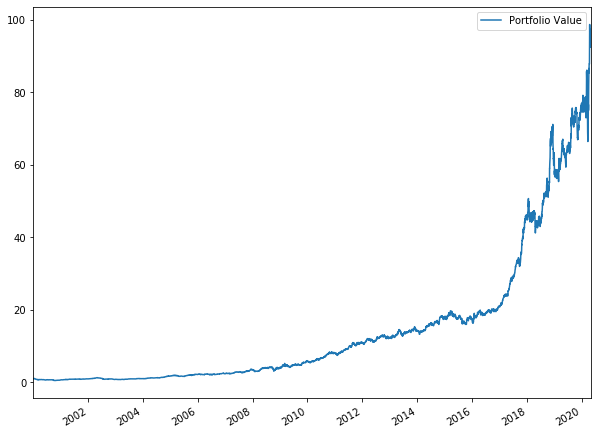

In [84]:
earnedcp = (1+earned[1:]).cumprod()
ecp = pd.DataFrame(data=earnedcp.T, index=logret.index.values[1:], columns=['Portfolio Value'])
ecp.plot(figsize=(10, 8));

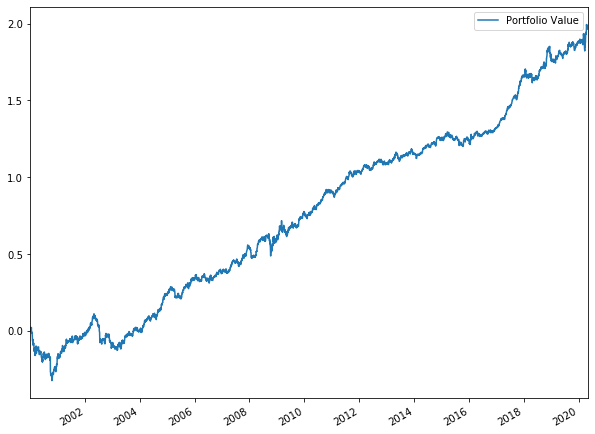

In [85]:
np.log10(ecp).plot(figsize=(10, 8));

In [86]:
ecp

,Portfolio Value
2000-01-04,0.994481
2000-01-05,1.011060
2000-01-06,1.016855
2000-01-07,1.055328
2000-01-10,1.026644
...,...
2020-05-04,95.387070
2020-05-05,95.868117
2020-05-06,96.133400
2020-05-07,96.833863


* 1 dollar invested in 2000 would be 96 dollars today?
* Unrealistic! Why?
* Having knowledge of 20 years worth of data is cheating!

    - The sigma matrix $\Sigma$ are computed from past 20-years worth of data; and optimal portfolio weight w used here is function of $\Sigma$ and $\mu$
    
    - The correct way is to use $\Sigma^\text{future}$ and $\mu^\text{future}$, which however is unknow.
    

### Quantify results

In [49]:
retinfo = logret.mean(axis=0).agg(['min', 'mean', 'max']) #mean return of each stock
stdinfo = logret.std(axis=0).agg(['min', 'mean', 'max']) #standard deviation of each stock
print('portfolio average returns:', earned.mean()) #minimum variance portfolio return
print('          average stddev :', earned.std())
print('')
print("component stocks average: minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(retinfo))
print("component stocks stddev : minimum: %f\n                          average: %f\n                          maximum: %f" % tuple(stdinfo))

portfolio average returns: 0.0009994070845034614
          average stddev : 0.01437021493694505

component stocks average: minimum: -0.000279
                          average: 0.000227
                          maximum: 0.000878
component stocks stddev : minimum: 0.012456
                          average: 0.019213
                          maximum: 0.029129


Annual return would be:

In [50]:
(1+earned.mean())**365 - 1

0.43993996760135157

Again, unrealistic

### Qualitative Visualization of Relationships

* Correlations are stricly pairwise quantities (what about other stocks?)
* Inverse covariance

In [88]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(logret.dropna().values)
scaled_df = pd.DataFrame(scaled_df, columns=logret.columns, index=logret.index[1:])

In [90]:
scaled_df.shape

(5119, 28)

In [92]:
scaled_df.loc['2020':'2020']

Symbol,AAPL,AXP,BA,BAC,CAT,CSCO,CVX,DD,DIS,GE,...,MMM,MRK,MSFT,PFE,PG,T,TRV,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,0.813415,0.617524,1.070342,0.403576,0.912327,0.690473,0.421930,-0.489267,1.251175,3.235703,...,1.316502,0.678204,0.924368,-0.075051,-0.881073,-0.349690,0.202431,-0.381219,0.042912,0.993178
2020-01-03,-0.399462,-0.444023,-0.094694,-0.723586,-0.701618,-0.673865,-0.217485,-0.948578,-0.615205,0.175293,...,-0.597419,-0.507853,-0.658204,-0.350722,-0.503529,0.305392,-0.208586,-0.703072,-0.599005,-0.516815
2020-01-06,0.264807,-0.197763,0.123997,-0.052567,-0.052677,0.145589,-0.213385,-0.318235,-0.318097,0.694674,...,0.041978,0.236413,0.116330,-0.091734,0.081078,0.055608,0.041975,-0.151350,-0.147440,0.472471
2020-01-07,-0.209805,-0.237499,0.484084,-0.230642,-0.668427,-0.266711,-0.759687,-0.690827,0.002078,-0.345707,...,-0.290436,-1.568723,-0.485470,-0.222283,-0.464896,0.226111,-0.809871,-0.733721,-0.628157,-0.525984
2020-01-08,0.565748,0.739225,-0.851554,0.341944,0.411358,0.025566,-0.680946,0.525708,-0.122850,-0.429220,...,0.992832,-0.399777,0.793975,0.493557,0.287176,0.178932,0.556482,0.106693,-0.239995,-0.965080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-04,0.494135,-0.978041,-0.697622,-0.227169,-1.429768,0.427735,1.260031,-0.348911,-1.171082,-2.190472,...,-0.111134,-0.615468,1.222604,-0.044057,-0.667433,-0.619451,0.462085,-0.685775,0.405541,2.479465
2020-05-05,0.525946,0.173543,-2.248084,-0.409943,0.515956,0.108483,0.891394,-0.033179,-1.094432,-0.064184,...,-0.458182,0.847910,0.531333,1.468531,0.130311,0.280174,-0.050082,0.296764,0.535581,-0.078996
2020-05-06,0.352131,-1.409858,-1.370017,-0.476202,-0.578218,-0.307600,-1.810889,-0.652705,-0.108382,-1.731082,...,-0.579393,-0.672704,0.486259,-0.010441,-1.844336,-1.979622,-2.028814,-1.013553,-0.775136,-1.199167


#### Correlation Matrix: 2020

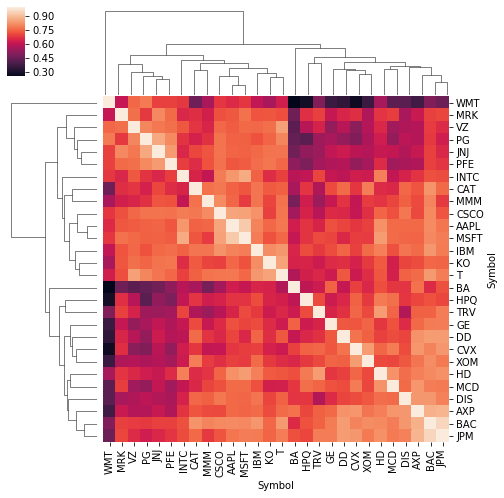

In [52]:
clmap = sns.clustermap(scaled_df.loc['2020':'2020'].corr(), square=True, figsize=(8, 8));
ordering = clmap.dendrogram_col.reordered_ind # save the hierarchical clustering generated variable ordering

#### Correlation Matrix: 2019 vs. 2020

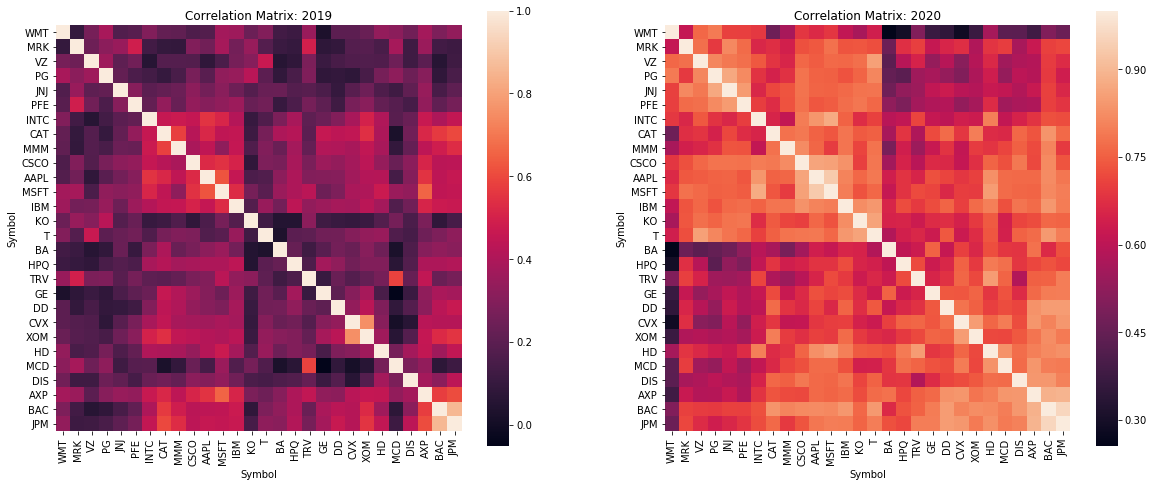

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(scaled_df.loc['2019':'2019'].corr().iloc[ordering, ordering],  square=True, ax=ax[0]).set_title('Correlation Matrix: 2019')
sns.heatmap(scaled_df.loc['2020':'2020'].corr().iloc[ordering, ordering],  square=True, ax=ax[1]).set_title('Correlation Matrix: 2020')
fig.show()

### Reality check

Obviously, this cannot be realistic. What aspects were unrealistic?

1. We didn't take time into consideration: e.g. estimation of $\Sigma$ and selecting `w`.
1. We are investing with knowledge of the future returns!
1. We did not take into account transaction costs (we will have to) 
1. We did not take into account shorting requires borrowing of money
1. Is investing in stocks better than leaving our money in a savings account? What is the interest rate?

Sharpe ratio tries to quantify the added benefit, i.e., excess returns, of investing in the volatile market by accounting for the volatility:
$$\text{Sharpe ratio}=\frac{E\left[R_{p}-R_{f}\right]}{\sigma_{p}}$$
where $R_f$ is the risk-free rate.

### Other considerations

1. Picking component stocks (choosing what to invest in)
    1. Playing the role of the fund manager
    1. Expertise about a specific market
    1. Warren Buffet says stick with long term _value_ investing strategies
    1. High-frequency trading makes money by constantly shuffling investments and making incremental returns
    1. Where is the middle ground? i.e., choosing strategies
1. Choosing monitoring strategies (keeping an eye out for changes in the market)
    1. Estimation of $\Sigma$ becomes challenging with shorter historical data
    1. "Regularized" estimates of $\Sigma$: Ledoit-Wolfe, Condition number, Sparsity inducing, Low-rank
    1. How big of a change in the market is signficant change?
    1. Where to look for a change? Component stocks? Market indices? Economic indicators? Consumer sentiment? Policy changes?
    1. Deciding when to take action. How big of a change warrants an action? (Actions cost money)
1. Choosing rebalancing strategy (deciding when to shuffle your investments)  
    1. Fixed intervals? dynamic intervals? 
    1. Allowing for shorts?
    1. If many component stocks, do you trade all of them even if the change is small? etc.

## Other optimization problems for modeling and learning

1. [Online advertising](https://github.com/UCSB-PSTAT-134-234/Spring2019/blob/master/labs/lab05/lab05.ipynb)
1. [Trend filtering](https://web.stanford.edu/~boyd/l1_tf/), [CVX example](https://www.cvxpy.org/examples/applications/l1_trend_filter.html)
1. [Catching a smuggler](https://www.cvxpy.org/examples/applications/interdiction.html)
1. [Estimating sparse inverse covariance matrix](https://www.cvxpy.org/examples/applications/sparse_covariance_est.html)
1. [Max-flow, Min-cut problem](https://www.cvxpy.org/examples/applications/OOCO.html)
1. Many more!!